# Cricket Match Outcome Prediction Model

This project aims to predict the outcome of cricket matches based on various features. The steps below outline the process from data preprocessing to model evaluation.

### 1. Import Libraries

Libraries such as pandas, scikit-learn, and matplotlib are imported for data manipulation, model building, and visualization.

In [208]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay


### 2. Data Loading

The dataset t20_wc24_match_data.csv is loaded into a DataFrame named df.


In [209]:
df = pd.read_csv('./data/t20_wc24_match_data.csv')

### Data Inspection:

The shape and data types of the DataFrame are checked.

In [210]:
df.shape

(1077, 15)

In [211]:
df.dtypes

Venue                  object
Date                   object
Team_A                 object
Team_B                 object
Team_A_Ranking          int64
Team_B_Ranking          int64
Winner                 object
Team_A_Score            int64
Team_A_Wickets_Lost     int64
Team_B_Score            int64
Team_B_Wickets_Lost     int64
Is_Home_Team_A          int64
Is_Home_Team_B          int64
Toss_Winner            object
Toss_Decision          object
dtype: object

The Date column is converted to datetime format.

In [212]:
df["Date"] = pd.to_datetime(df["Date"])

### Missing Values:

Check for missing values using df.isnull().sum()

In [213]:
df.isnull().sum()

Venue                   0
Date                    0
Team_A                  0
Team_B                  0
Team_A_Ranking          0
Team_B_Ranking          0
Winner                 47
Team_A_Score            0
Team_A_Wickets_Lost     0
Team_B_Score            0
Team_B_Wickets_Lost     0
Is_Home_Team_A          0
Is_Home_Team_B          0
Toss_Winner             0
Toss_Decision           0
dtype: int64

Drop rows where the 'Winner' column is NaN.

In [214]:
df.dropna(subset=['Winner'], inplace=True)

### Encoding:

Use LabelEncoder to transform the Toss_Decision column into numerical format.

In [215]:
le = LabelEncoder()
df['Toss_Decision'] = le.fit_transform(df['Toss_Decision'])

In [216]:
df.tail(1)

,Venue,Date,Team_A,Team_B,Team_A_Ranking,Team_B_Ranking,Winner,Team_A_Score,Team_A_Wickets_Lost,Team_B_Score,Team_B_Wickets_Lost,Is_Home_Team_A,Is_Home_Team_B,Toss_Winner,Toss_Decision
1076,R Premadasa Stadium,2016-09-09,Sri Lanka,Australia,8,2,Australia,128,9,130,6,0,0,Sri Lanka,0


Encode teams for 'Winner' and 'Toss_Winner' using the encode_team function and drop the original columns.

In [217]:
def encode_team(row, column):
    if row[column] == row['Team_A']:
        return 0
    elif row[column] == row['Team_B']:
        return 1

In [218]:
df['Winner_Encoded'] = df.apply(lambda row: encode_team(row, 'Winner'), axis=1)
df['Toss_Winner_Encoded'] = df.apply(lambda row: encode_team(row, 'Toss_Winner'), axis=1)
df.drop(columns=['Winner', 'Toss_Winner'], inplace=True)
df.rename(columns={'Winner_Encoded': 'Winner', 'Toss_Winner_Encoded': 'Toss_Winner'}, inplace=True)


### 3. Feature Engineering

Calculate recent performance for each team, including win rate, runs scored, and wickets lost, using the calculate_recent_performance function.

In [219]:
def calculate_recent_performance(team, date, df, num_matches=5):

    past_matches = df[((df['Team_A'] == team) | (df['Team_B'] == team)) & (df['Date'] < date)]
    past_matches = past_matches.sort_values(by='Date', ascending=False).head(num_matches)

    wins = 0
    for _, match in past_matches.iterrows():
        if match['Team_A'] == team and match['Winner'] == 0:
            wins += 1
        elif match['Team_B'] == team and match['Winner'] == 1:
            wins += 1
    win_rate = (wins / num_matches) * 100

    runs_scored = 0
    wickets_lost = 0

    for _, match in past_matches.iterrows():
        if match['Team_A'] == team:
            runs_scored += match['Team_A_Score']
            wickets_lost += match['Team_A_Wickets_Lost']
        elif match['Team_B'] == team:
            runs_scored += match['Team_B_Score']
            wickets_lost += match['Team_B_Wickets_Lost']

    return win_rate, runs_scored, wickets_lost

Add new columns for Team_A and Team_B recent form, runs, and wickets.

In [220]:
df[['Team_A_Recent_Form', 'Team_A_Recent_Runs', 'Team_A_Recent_Wickets']] = df.apply(
    lambda x: pd.Series(calculate_recent_performance(x['Team_A'], x['Date'], df)), axis=1
)
df[['Team_B_Recent_Form', 'Team_B_Recent_Runs', 'Team_B_Recent_Wickets']] = df.apply(
    lambda x: pd.Series(calculate_recent_performance(x['Team_B'], x['Date'], df)), axis=1
)

Calculate head-to-head win rates for Team_A and Team_B using the calculate_head_to_head_win_rate function and add the results as new columns.

In [221]:
def calculate_head_to_head_win_rate(team_a, team_b, date, matches_df, num_matches=5):
    past_matches = matches_df[((matches_df['Team_A'] == team_a) & (matches_df['Team_B'] == team_b) |
                                (matches_df['Team_A'] == team_b) & (matches_df['Team_B'] == team_a)) & (matches_df['Date'] < date)]
    past_matches = past_matches.sort_values(by='Date', ascending=False).head(num_matches)

    wins_team_a = 0
    wins_team_b = 0

    for index, match in past_matches.iterrows():
        if match['Team_A'] == team_a and match['Winner'] == 0:
            wins_team_a += 1
        elif match['Team_B'] == team_a and match['Winner'] == 1:
            wins_team_a += 1
        elif match['Team_A'] == team_b and match['Winner'] == 0:
            wins_team_b += 1
        elif match['Team_B'] == team_b and match['Winner'] == 1:
            wins_team_b += 1

    # Calculate the win rates
    total_matches = len(past_matches)
    win_rate_team_a = (wins_team_a / total_matches) * 100 if total_matches > 0 else 0
    win_rate_team_b = (wins_team_b / total_matches) * 100 if total_matches > 0 else 0

    return win_rate_team_a, win_rate_team_b

In [222]:
df[['win_rate_team_a', 'win_rate_team_b']] = df.apply(lambda x: pd.Series(calculate_head_to_head_win_rate(x['Team_A'], x['Team_B'], x['Date'], df)), axis=1)

In [223]:
df.tail(1)

,Venue,Date,Team_A,Team_B,Team_A_Ranking,Team_B_Ranking,Team_A_Score,Team_A_Wickets_Lost,Team_B_Score,Team_B_Wickets_Lost,...,Winner,Toss_Winner,Team_A_Recent_Form,Team_A_Recent_Runs,Team_A_Recent_Wickets,Team_B_Recent_Form,Team_B_Recent_Runs,Team_B_Recent_Wickets,win_rate_team_a,win_rate_team_b
1076,R Premadasa Stadium,2016-09-09,Sri Lanka,Australia,8,2,128,9,130,6,...,1,0,0.0,721.0,46.0,60.0,907.0,29.0,80.0,20.0


### Date Features:

Extract the year, month, and day from the Date column and add them as new features.

In [224]:
df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month
df['Day']=df['Date'].dt.day

In [225]:
df.tail(1)

,Venue,Date,Team_A,Team_B,Team_A_Ranking,Team_B_Ranking,Team_A_Score,Team_A_Wickets_Lost,Team_B_Score,Team_B_Wickets_Lost,...,Team_A_Recent_Runs,Team_A_Recent_Wickets,Team_B_Recent_Form,Team_B_Recent_Runs,Team_B_Recent_Wickets,win_rate_team_a,win_rate_team_b,Year,Month,Day
1076,R Premadasa Stadium,2016-09-09,Sri Lanka,Australia,8,2,128,9,130,6,...,721.0,46.0,60.0,907.0,29.0,80.0,20.0,2016,9,9


### 4. Model Training and Evaluation

    1. Define the features to be used for training the model, including date components, venue, team rankings, recent form, and head-to-head win rates.

    2. Set Winner as the target variable.

In [226]:
features = [
    'Day' , 'Month', 'Year' ,'Venue', 'Is_Home_Team_A', 'Is_Home_Team_B', 'Toss_Decision',
    'Toss_Winner', 'Team_A_Ranking', 'Team_B_Ranking', 'Team_A_Recent_Form',
    'Team_B_Recent_Form', 'Team_A_Recent_Runs', 'Team_A_Recent_Wickets',
    'Team_B_Recent_Runs', 'Team_B_Recent_Wickets' ,'win_rate_team_a',
       'win_rate_team_b'
]
target = 'Winner'


Split the data into training and test sets with a 75-25 split.

In [227]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Use ColumnTransformer to preprocess features:

    1. One-hot encode the Venue feature.
    2. Standardize numerical features.
    3. Pass binary features through without change.

In [228]:
preprocessor = ColumnTransformer(
    transformers=[
        ('venue', OneHotEncoder(handle_unknown='ignore'), ['Venue']),
        ('num', StandardScaler(), [
            'Day' , 'Month', 'Year','Team_A_Ranking', 'Team_B_Ranking',
            'Team_A_Recent_Form', 'Team_B_Recent_Form', 'Team_A_Recent_Runs',
            'Team_A_Recent_Wickets', 'Team_B_Recent_Runs', 'Team_B_Recent_Wickets' ,'win_rate_team_a',
       'win_rate_team_b'
        ]),
        ('bin', 'passthrough', ['Is_Home_Team_A', 'Is_Home_Team_B', 'Toss_Decision', 'Toss_Winner'])
    ]
)

Model Training:

     1. Define a Pipeline with the preprocessing steps and a GradientBoostingClassifier model.
     2. Train the model using the training data.
    

In [229]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(n_estimators=50, criterion='squared_error', random_state=42))
])

In [230]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('venue',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Venue']),
                                                 ('num', StandardScaler(),
                                                  ['Day', 'Month', 'Year',
                                                   'Team_A_Ranking',
                                                   'Team_B_Ranking',
                                                   'Team_A_Recent_Form',
                                                   'Team_B_Recent_Form',
                                                   'Team_A_Recent_Runs',
                                                   'Team_A_Recent_Wickets',
                                                   'Team_B_Recent_Runs',
                                                   'Team_B_Recent_Wickets',
                                                   'win_rate_team_a',
                                                   'win_rate_team_b']),
                                                 ('bin', 'passthrough',
                                                  ['Is_Home_Team_A',
                                                   'Is_Home_Team_B',
                                                   'Toss_Decision',
                                                   'Toss_Winner'])])),
                ('model',
                 GradientBoostingClassifier(criterion='squared_error',
                                            n_estimators=50,
                                            random_state=42))])

### 4. Prediction and Evaluation:

    1. Make predictions on the test set.
    2. Print a classification report to evaluate model performan2e.

In [231]:
y_pred = pipeline.predict(X_test)

In [232]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65       126
           1       0.67      0.58      0.62       132

    accuracy                           0.64       258
   macro avg       0.64      0.64      0.63       258
weighted avg       0.64      0.64      0.63       258



In [233]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.64
F1-score: 0.62
Precision: 0.67
Recall: 0.58


Text(0.5, 1.0, 'gradient Boosting Classifier')

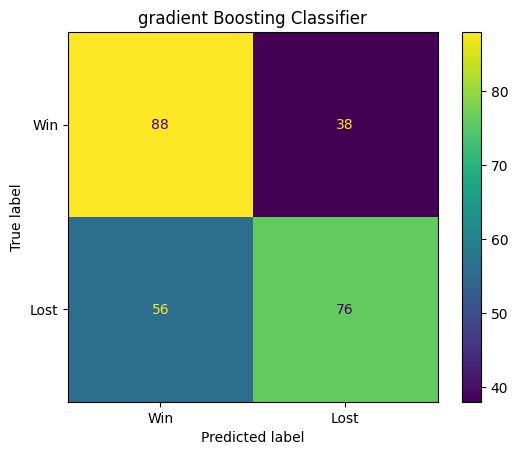

In [234]:
matrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Win', 'Lost'])
cm.plot()
plt.title(label='gradient Boosting Classifier')

### Feature Importance Analysis

    1. Get the feature importances from the model


In [235]:
classifier = pipeline.named_steps['model']
importances = classifier.feature_importances_

    2. Get the feature names from the preprocessor

In [236]:
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['venue'].get_feature_names_out(['Venue'])
all_feature_names = np.concatenate([
    [
        'Day', 'Month', 'Year','Team_A_Ranking', 'Team_B_Ranking',
        'Team_A_Recent_Form', 'Team_B_Recent_Form', 'Team_A_Recent_Runs',
        'Team_A_Recent_Wickets', 'Team_B_Recent_Runs', 'Team_B_Recent_Wickets',
        'win_rate_team_a', 'win_rate_team_b',
        'Is_Home_Team_A', 'Is_Home_Team_B', 'Toss_Decision', 'Toss_Winner'
    ],
    onehot_columns
])


    3. Create a DataFrame for the feature importances

In [237]:
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

    4. Summarize venue importances if they dominate

In [238]:
venue_importances = feature_importance_df[feature_importance_df['Feature'].str.startswith('Venue')]['Importance'].sum()
other_importances = feature_importance_df[~feature_importance_df['Feature'].str.startswith('Venue')]


    5. Print the importances

In [239]:
print("Total Venue Importance:", venue_importances)
print("Other Features Importance:")
print(other_importances.sort_values(by='Importance', ascending=False))


Total Venue Importance: 0.9820178414644996
Other Features Importance:
                  Feature  Importance
15          Toss_Decision    0.011612
2                    Year    0.005088
4          Team_B_Ranking    0.001282
0                     Day    0.000000
10  Team_B_Recent_Wickets    0.000000
14         Is_Home_Team_B    0.000000
13         Is_Home_Team_A    0.000000
12        win_rate_team_b    0.000000
11        win_rate_team_a    0.000000
8   Team_A_Recent_Wickets    0.000000
9      Team_B_Recent_Runs    0.000000
1                   Month    0.000000
7      Team_A_Recent_Runs    0.000000
6      Team_B_Recent_Form    0.000000
5      Team_A_Recent_Form    0.000000
3          Team_A_Ranking    0.000000
16            Toss_Winner    0.000000


The total importance of venue features was found to be very high, suggesting they dominate the model's decision-making process. To assess the impact of this, we drop the venue features and re-train the model.

#### Re-train the model

    1. Drop the Venue column and re-train the model
    2. Split the data into training and testing sets

In [240]:
X_no_venue = X.drop(columns=['Venue'])


X_train_no_venue, X_test_no_venue, y_train, y_test = train_test_split(X_no_venue, y, test_size=0.2, random_state=42)


    3. Define the preprocessor without Venue

In [241]:
preprocessor_no_venue = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [
            'Day', 'Month', 'Year','Team_A_Ranking', 'Team_B_Ranking',
            'Team_A_Recent_Form', 'Team_B_Recent_Form', 'Team_A_Recent_Runs',
            'Team_A_Recent_Wickets', 'Team_B_Recent_Runs', 'Team_B_Recent_Wickets' ,'win_rate_team_a',
            'win_rate_team_b'
        ]),
        ('bin', 'passthrough', ['Is_Home_Team_A', 'Is_Home_Team_B', 'Toss_Decision', 'Toss_Winner'])
    ]
)


    4. Create the pipeline without Venue and fit the pipeline

In [242]:
pipeline_no_venue = Pipeline(steps=[
    ('preprocessor', preprocessor_no_venue),
    ('classifier', GradientBoostingClassifier(random_state=42))
])


In [243]:
pipeline_no_venue.fit(X_train_no_venue, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Day', 'Month', 'Year',
                                                   'Team_A_Ranking',
                                                   'Team_B_Ranking',
                                                   'Team_A_Recent_Form',
                                                   'Team_B_Recent_Form',
                                                   'Team_A_Recent_Runs',
                                                   'Team_A_Recent_Wickets',
                                                   'Team_B_Recent_Runs',
                                                   'Team_B_Recent_Wickets',
                                                   'win_rate_team_a',
                                                   'win_rate_team_b']),
                                                 ('bin', 'passthrough',
                                                  ['Is_Home_Team_A',
                                                   'Is_Home_Team_B',
                                                   'Toss_Decision',
                                                   'Toss_Winner'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

    5. Evaluate the new model

In [251]:
train_accuracy = pipeline_no_venue.score(X_train_no_venue, y_train)
test_accuracy = pipeline_no_venue.score(X_test_no_venue, y_test)
y_pred = pipeline_no_venue.predict(X_test_no_venue)


In [252]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [253]:
print("Model performance without 'Venue' features:")
print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Model performance without 'Venue' features:
Accuracy: 0.64
F1-score: 0.64
Precision: 0.66
Recall: 0.62


    6. Extract and display feature importances


In [245]:
importances_no_venue = pipeline_no_venue.named_steps['classifier'].feature_importances_


    6. Create a DataFrame for the feature importances


In [246]:
feature_names_no_venue = X_no_venue.columns
feature_importance_df_no_venue = pd.DataFrame({
    'Feature': feature_names_no_venue,
    'Importance': importances_no_venue
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_no_venue)

                  Feature  Importance
9      Team_A_Recent_Form    0.133852
3          Is_Home_Team_A    0.130071
4          Is_Home_Team_B    0.121101
7          Team_A_Ranking    0.112508
8          Team_B_Ranking    0.083360
0                     Day    0.062315
2                    Year    0.056979
1                   Month    0.056212
6             Toss_Winner    0.050782
5           Toss_Decision    0.049166
10     Team_B_Recent_Form    0.042447
12  Team_A_Recent_Wickets    0.034172
14  Team_B_Recent_Wickets    0.031587
11     Team_A_Recent_Runs    0.028415
15        win_rate_team_a    0.004314
16        win_rate_team_b    0.001902
13     Team_B_Recent_Runs    0.000819


#### Visualize Feature Importances:

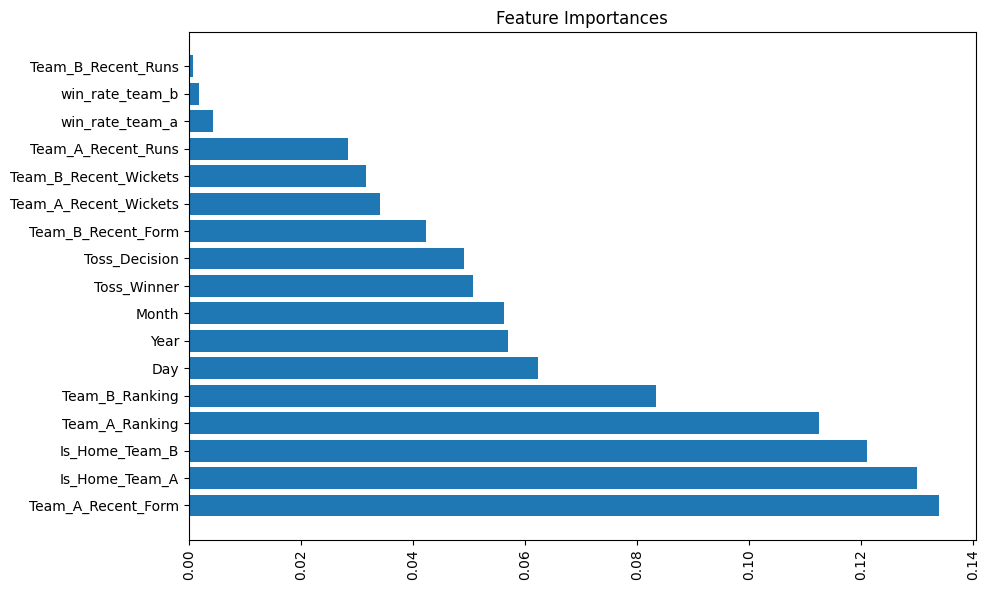

In [247]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_no_venue['Feature'], feature_importance_df_no_venue['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


## Conclusion

Before removing the venue features, the model achieved an accuracy of 64.00%. After excluding these features, the model's accuracy remained at 64%. This suggests that while venue features were highly influential, their removal did not significantly impact the overall performance of the model.

### Feature Importance Analysis

- **Top Influential Features**: The most important features after removing venue data are `Team_A_Recent_Form`, `Is_Home_Team_A`, and `Is_Home_Team_B`. This indicates that recent performance and home advantage are key factors in the model's predictions.
- **Comparative Importance**: The influence of features like team rankings and recent form remains significant, emphasizing their predictive value.
- **Minor Features**: Features such as `win_rate_team_a` and `win_rate_team_b` have low importance, suggesting they contribute less to the model's predictions.

This analysis highlights that, although venue features carried a substantial weight in the model, the performance remained stable without them. It is crucial to further explore other feature engineering and selection techniques to enhance model accuracy and interpretability.
